# Задача
В рамках максимум одного дня потраченного времени обучить на классическом датасете https://ru.wikipedia.org/wiki/Ирисы_Фишера (https://archive.ics.uci.edu/ml/datasets/iris) любой алгоритм классификации с использованием любой python библиотеки и оценить качество его работы.

Результат - код и пара абзацев текста, что было сделано и какие результаты. 

# Результат
### Исследование датасета
Датасет содержит:
- 150 наблюдений, 
- 4 числовых признака
- 1 категориальный (целевой) признак, разделённый на 3 класса цветков ириса.<br>
Пропуски данных отсутствуют

**Характеристики признаков**:
- признаки `sepal length` и `petal width` имеют симметричные распределения близкие к нормальному
- признаки `petal length` и `sepal width` имею бимодальные распределеня
- датасет хорошо сбалансирован по целевому признаку, поэтому для оценки качества модели можно взять метрику `accuracy`

**Взаимосвязи признаков**
- класс `iris-setosa` хорошо отделяется по признакам `petal length` и `petal width`
- большинство признаков линейно-зависимы с коррелицией близкой к `1`. Комбинируя эти признаки можно построить новые, способные улучшить качество модели.
- `petal length` и `petal width` наиболее сильно влияют на целевой признак `class`, также эта пара признаков сильно коррелирована между собой

### Построение и обучение модели
- в качества модели выбран алгоритм XGBClassifier. Его плюсы: низкая чувствительность к качеству данных (масштаб, выбросы). Недостаток - требует настройки гиперпараметров
- для деления на обучающую и тестовую выборки, а также оценки качества модели использовалас кроссвалидация
- с помощью `GridSearchCV` выполнена настройка гиперпараметров, оптимальные значения которых следующие {'eta': 0.03, 'learning_rate': 0.0005, 'max_depth': 3, 'n_estimators': 4, 'tree_method': 'exact'}
- Точность модели на кроссвалидации составила 0.967

### Дальнейшие действия по улучшению модели
 За счёт комбинации коррелируемых признов можно уменьшить их количество и повысить качество модели. Имеет смысл для этого попробовать методы понижения размерности PCA

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')
data_files = os.listdir('data')

In [2]:
col_names = ['sepal length', 'sepal width', 'petal length', 'petal width', 'class']
df = pd.read_csv('data/iris.data', names=col_names)
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


**Размерность датафрейма**

In [3]:
df.shape

(150, 5)

# 1. Explore data
Цель: предсказать класс цветка ириса.

Размерность датафрейма и категори признаков по типу данных

Датасет содержит:
- 150 наблюдений, 
- 4 числовых признака
- 1 категориальный (целевой) признак, разделённый на 3 класса цветков ириса.<br>
Пропуски данных отсутствуют

признаки sepal length и petal width имеют симметричные распределения близкие к нормальному
признаки petal length и sepal width имею бимодальные распределеня

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


**Характеристики числовых признаков**

In [5]:
df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


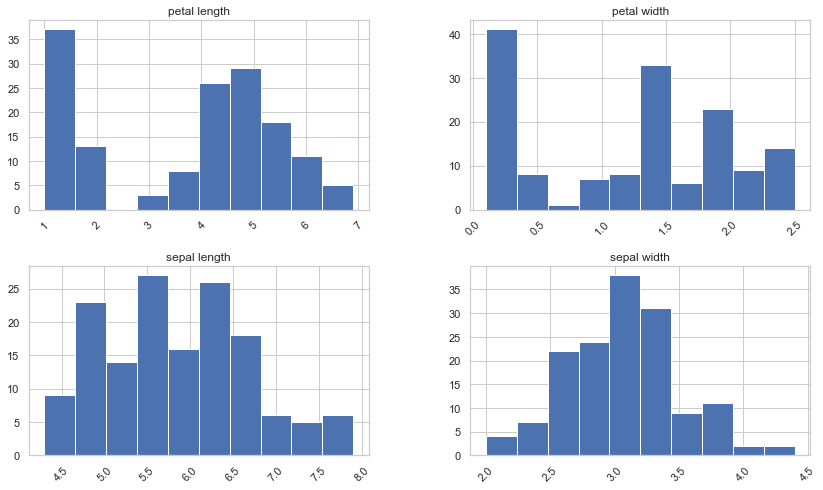

In [6]:
df.hist(figsize=(14,8), xrot=45);

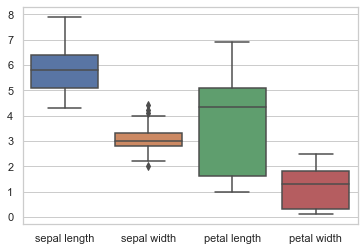

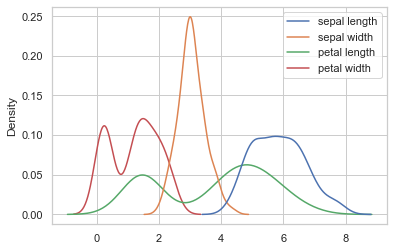

In [7]:
sns.boxplot(data=df); plt.show()
sns.kdeplot(data=df);

- признаки `sepal length` и `petal width` имеют симметричные распределения близкие к нормальному
- признаки `petal length` и `sepal width` имею бимодальные распределеня

**Статистика классов категориального целевого признака**

In [8]:
df.describe(include='object')

,class
count,150
unique,3
top,Iris-virginica
freq,50


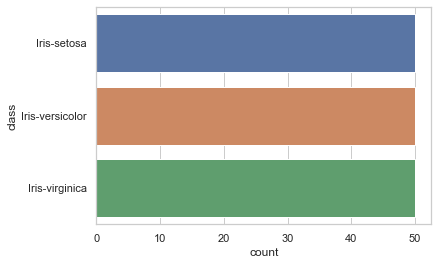

In [9]:
sns.countplot(y='class', data=df);

датасет хорошо сбалансирован по целевому признаку, поэтому для оценки качества модели можно взять метрику `accuracy`

**Взаимосвязи признаков**

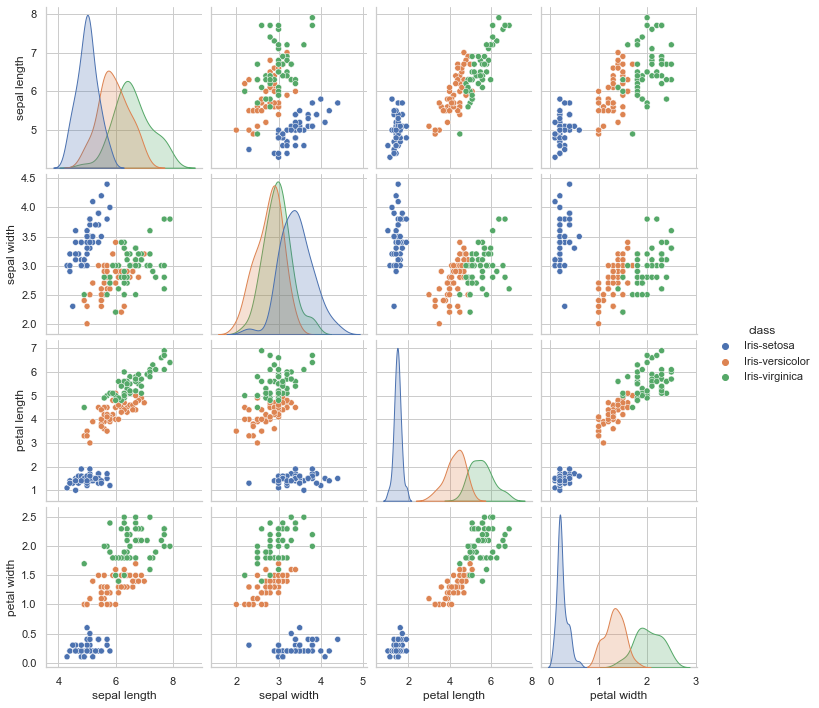

In [10]:
sns.pairplot(data=df, hue='class');

- Класс `iris-setosa` хорошо отделяется по признакам `petal length` и `petal width`
- есть пары линейно-зависимых признаков. Оценим эти зависимости по матрице коррелиции 

**Матрица корреляций признаков между собой и целевым призгаком**

In [11]:
num2class = df['class'].unique()
class2num = {iris_class: i for i, iris_class in enumerate(df['class'].unique())}
df_modif = df.copy()
df_modif['class']=df_modif['class'].map(class2num)
df_modif.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Text(0.5, 1.05, 'Pearson correlation of features')

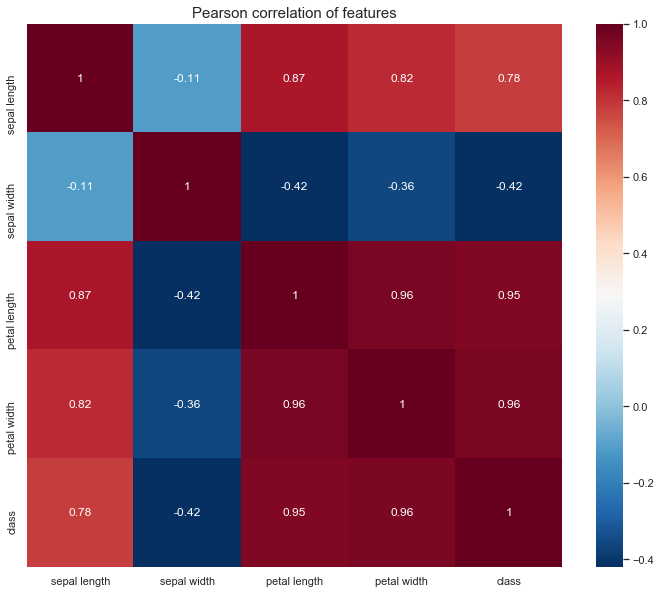

In [12]:
plt.figure(figsize=(12,10))
sns.heatmap(df_modif.corr(), cmap='RdBu_r', annot=True)
plt.title('Pearson correlation of features', y=1.05, size=15)

In [13]:
df_modif.corr()['class'].sort_values(ascending=False)

class           1.000000
petal width     0.956464
petal length    0.949043
sepal length    0.782561
sepal width    -0.419446
Name: class, dtype: float64

- по диаграмме корреляции признаков много пар с коррелицией близкой к `1`. Комбинируя эти признаки можно построить новые, способные улучшить качество модели.
- `petal length` и `petal width` наиболее сильно влияют на целевой признак `class`, также эта пара признаков сильно коррелирована между собой
- Таким образом, за счёт комбинации коррелируемых признов можно уменьшить их количество и повысить качество модели. Имеет смысл для этого попробовать методы понижения размерности

# 2. Data preprocessing

In [14]:
labels = df['class'].unique()
df['class'] = df['class'].map({label:i for i, label in enumerate(labels)})
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# 3. Extract Features and Target

In [15]:
import numpy as npExtract
y = df['class']
X = df.drop(['class'], axis=1)

# 4. XGBClassifier
для разделения на обучающую и тестовую выборки, а также оценки её качества будем использовать кроссвалидацию 

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier

In [17]:
%%time
xgboost_model = XGBClassifier(random_state=1, num_class=3)
np.mean(cross_val_score(xgboost_model, X, y, cv=5))

Wall time: 189 ms


0.96

**hyperparameter tuning**

In [18]:
xgboost_param = {
    'n_estimators':np.arange(1, 6, 1), # Number of gradient boosted trees
    'max_depth': np.arange(1, 6, 1),  # the maximum depth of each tree
    'eta': [0.03, 0.05, .1, 0.3, 0.5],  # the training step for each iteration
    'tree_method':['exact', 'approx', 'hist'],
    'learning_rate':[.0001,.0003,.0005,.001,.003,.005],
}

xgboost_grid = GridSearchCV(xgboost_model, xgboost_param, scoring='accuracy', 
                            cv=5, n_jobs=-1, verbose=1)

In [19]:
%%time
progress = dict()
xgboost_grid.fit(X, y);
print(f'best_score: {xgboost_grid.best_score_:.3f}')
print(xgboost_grid.best_params_)

Fitting 5 folds for each of 2250 candidates, totalling 11250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 6380 tasks      | elapsed:   23.7s


best_score: 0.967
{'eta': 0.03, 'learning_rate': 0.0005, 'max_depth': 3, 'n_estimators': 4, 'tree_method': 'exact'}
Wall time: 42.2 s


[Parallel(n_jobs=-1)]: Done 11250 out of 11250 | elapsed:   41.9s finished
